# Answering Business Questions using SQL

## Index

 * [Intro](#Intro)
 * [Import libraries and create helpers](#Import-libraries-and-read-data) 
 * [Selecting Albums to Purchase](#selecting-albums-to-purchase)
 * [Analyzing Employee Sales Performance](#Analyzing-Employee-Sales-Performance)
 * [Analyzing Sales by Country](#Analyzing-Sales-by-Country)
 * [Visualizing Sales by Country](#Visualizing-Sales-by-Country)
 * [Albums vs Individual Tracks](#Albums-vs-Individual-Tracks)

---
## <a id='intro'></a> Intro
[Back](#Index)

In this project, we're going to use the Chinook database. The Chinook database is provided as a SQLite database file called `chinook.db`, A copy of the database schema is below:

![Alt text](chinook-schema.svg)

---
## <a id='Import-libraries-and-read-data'></a> Import libraries and create helpers
[Back](#Index)

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import functools
from inspect import signature

%matplotlib inline

#### Colors

In [26]:
blue = (0, 107/255, 164/255)
electric_blue = (131/255, 196/255, 220/255)
light_blue = (191/255, 219/255, 237/255)
orange = (1, 128/255, 14/255)
red = (200/255, 52/255, 0/255)
light_orange = (255/255, 188/255, 121/255)

#### Helpers

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def create_function(name, func):
    with sqlite3.connect('chinook.db') as conn:
        conn.create_function(name, len(signature(run_query).parameters), func)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    return run_query('''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
    ''')

#### Views

In [4]:
run_command('''DROP VIEW track_data;''')
run_command('''
    CREATE VIEW track_data AS 
    SELECT 
        t.track_id, 
        il.invoice_line_id, 
        t.unit_price, 
        il.quantity, 
        i.invoice_id, 
        i.total, 
        t.name, 
        g.name genre, 
        c.first_name || ' ' || c.last_name customer,
        e.employee_id,
        e.first_name || ' ' || e.last_name support_agent
    FROM track t
    INNER JOIN invoice_line il ON il.track_id == t.track_id
    INNER JOIN genre g ON g.genre_id == t.genre_id
    INNER JOIN invoice i ON i.invoice_id == il.invoice_id 
    INNER JOIN customer c ON c.customer_id == i.invoice_id
    INNER JOIN employee e ON c.support_rep_id == e.employee_id;
''')

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


---
## <a id="selecting-albums-to-purchase"></a> Selecting Albums to Purchase
[Back](#Index)

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|:--------------------:|:-------:|
| Regal	               | Hip-Hop |
| Red Tone	           | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites	   | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [6]:
results = run_query('''
    WITH from_usa AS (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id == il.invoice_id
        WHERE i.billing_country == 'USA'
    )

    SELECT 
        g.name, 
        COUNT(t.track_id) tracks_purchased,
        CAST(COUNT(t.track_id) AS FLOAT)/
            (SELECT COUNT(*) FROM from_usa) tracks_purchased_ratio
    FROM from_usa u
    INNER JOIN track t ON t.track_id == u.track_id
    INNER JOIN genre g ON g.genre_id == t.genre_id
    GROUP BY t.genre_id
    ORDER BY tracks_purchased DESC
''');
results

,name,tracks_purchased,tracks_purchased_ratio
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [7]:
results.set_index('name', drop=True, inplace=True)

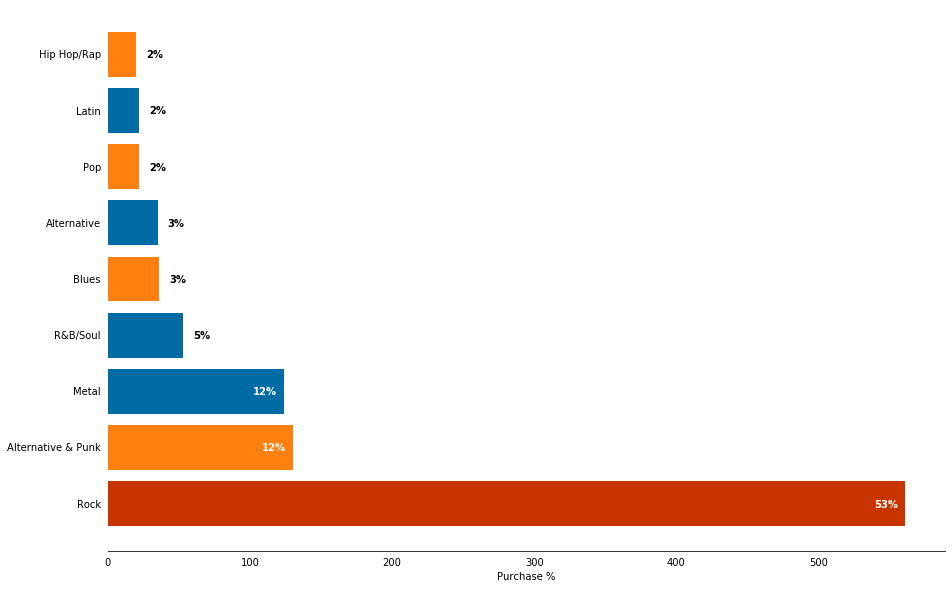

In [8]:
results['tracks_purchased_percent'] = round(results['tracks_purchased_ratio']*100).astype(int)

to_graph = results[results['tracks_purchased_percent']>1]
given_genres = ['Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues']

colors = []
for i, label in enumerate(list(to_graph.index)):
    if label in given_genres:
        colors.append(orange)
    else:
        colors.append(blue)
colors[0] = red

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.barh(
    to_graph.index, 
    to_graph.loc[:, ['tracks_purchased']]['tracks_purchased'].tolist(), 
    color=colors)

plt.tick_params(bottom = False, left = False, labelbottom = True)

for i, label in enumerate(list(to_graph.index)):
    score = to_graph.loc[label, "tracks_purchased"]
    percent = to_graph.loc[label, 'tracks_purchased_percent']
    percent_str = to_graph.loc[label, 'tracks_purchased_percent'].astype(str)+'%'
    if percent > 10:
        plt.annotate(percent_str, (score-22, i-0.07), weight='bold', color='w')
    else:
        plt.annotate(percent_str, (score+7, i-0.07), weight='bold')
    
ax.set_xlabel('Purchase %')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().get_label().set_visible(True)

plt.show()

Surely the most purchased genres, between the ones associated with the artists of the new record label (orange), are in a descent order `Alternative & Punk` (12%), `Blues` (3%) and `Pop` (2%).

However is important to notice that while these top three are, together, only the 17% of the purchases, `Rock` alone rapresent more than half of all purchases from USA.

---
## <a id='Analyzing-Employee-Sales-Performance'></a> Analyzing Employee Sales Performance
[Back](#Index)

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We've to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

The next query will give data about employee tracks sold.

In [9]:
employee_data = run_query('''
    WITH tracks_sold AS (
        SELECT 
            COUNT(t.track_id) total_tracks
        FROM employee e
        INNER JOIN customer c ON c.support_rep_id == e.employee_id
        INNER JOIN invoice i ON i.customer_id == c.customer_id
        INNER JOIN track_data t ON t.invoice_id == i.invoice_id
    )
    
    SELECT 
        e.employee_id,
        e.first_name || ' ' || e.last_name support_agent, 
        e.hire_date,
        SUM(i.total) total, 
        COUNT(t.track_id) total_tracks, 
        (COUNT(t.track_id)/SUM(i.total)) ratio_tracks_total,
        (COUNT(t.track_id)/CAST((SELECT * FROM tracks_sold) as float)) total_tracks_perc,
        MIN(i.invoice_date) from_date, 
        MAX(i.invoice_date) to_date
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id == e.employee_id
    INNER JOIN invoice i ON i.customer_id == c.customer_id
    INNER JOIN track_data t ON t.invoice_id == i.invoice_id
    GROUP BY e.employee_id
''')

employee_data

,employee_id,support_agent,hire_date,total,total_tracks,ratio_tracks_total,total_tracks_perc,from_date,to_date
0,3,Jane Peacock,2017-04-01 00:00:00,2571.03,249,0.096848,0.530917,2017-01-03 00:00:00,2017-04-24 00:00:00
1,4,Margaret Park,2017-05-03 00:00:00,1908.72,174,0.091161,0.371002,2017-01-05 00:00:00,2017-04-23 00:00:00
2,5,Steve Johnson,2017-10-17 00:00:00,362.34,46,0.126953,0.098081,2017-01-10 00:00:00,2017-03-25 00:00:00


As we can see, Steve Johnson has the lowest total but also the highest ratio tracks sold on total, try to visualize this data:

In [10]:
employee_data.set_index('support_agent', drop=True, inplace=True)

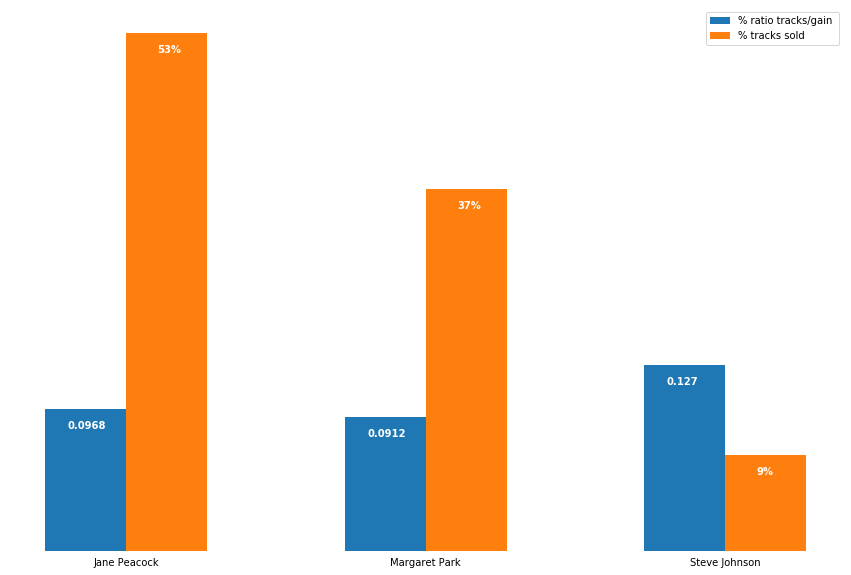

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

N = 3
ind = np.arange(N) 
width = 0.27 

plt.tick_params(bottom = False, left = False, labelbottom = True)
plt.gca().axes.get_yaxis().set_visible(False)

rects1 = ax.bar(
    ind,
    (employee_data['ratio_tracks_total']*1.5).tolist(), 
    width)
rects2 = ax.bar(
    ind+width,
    employee_data['total_tracks_perc'].tolist(), 
    width)

for i, label in enumerate(list(employee_data.index)):
    
    total_perc = employee_data.loc[label, "ratio_tracks_total"]*1.5
    total_perc_str = (round(employee_data.loc[label, "ratio_tracks_total"], 4)).astype(str)
    total_tracks_perc = employee_data.loc[label, 'total_tracks_perc']
    total_tracks_perc_str = (employee_data.loc[label, 'total_tracks_perc']*100).astype(int).astype(str)+'%'
    
    plt.annotate(total_perc_str, (ind[i]-0.06, total_perc-0.02), weight='bold', color='w')
    plt.annotate(total_tracks_perc_str, (ind[i]+width-0.03, total_tracks_perc-0.02), weight='bold', color='w')
    
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().get_label().set_visible(False)

ax.set_xticks(ind+(width/2))
ax.set_xticklabels(employee_data.index)
ax.legend((rects1[0], rects2[0]), ('% ratio tracks/gain ', '% tracks sold') )
plt.show()

Why? We'll visualize data about track sold by employees dividing by genre:

In [12]:
genres = run_query('''
    SELECT genre_id, name
    FROM genre
''');

genres['name_normalized'] = genres['name'].str.lower().str.replace('&','and').str.replace(' ', '_').str.replace('/', '_')
genres['colors'] = [np.random.rand(3,) for i in range(0, genres['name_normalized'].count())]

def purchase_columns_by_genres(employee_id, genres):
    return ','.join([f'''
        (
            SELECT COUNT(tr.track_id) 
                FROM track_data tr
                WHERE 
                    tr.employee_id == {employee_id} AND 
                    tr.genre == '{genre.encode('latin-1').decode('unicode_escape')}'
        ) {genre.lower().replace('&','and').replace(' ', '_').replace('/', '_')},
        (
            SELECT SUM(tr.unit_price) 
                FROM track_data tr
                WHERE 
                    tr.employee_id == {employee_id} AND 
                    tr.genre == '{genre.encode('latin-1').decode('unicode_escape')}'
        ) {genre.lower().replace('&','and').replace(' ', '_').replace('/', '_')}_total_unit_price,
        (
            SELECT SUM(total) FROM (
                SELECT *
                    FROM track_data tr
                    WHERE 
                        tr.employee_id == {employee_id} AND 
                        tr.genre == '{genre.encode('latin-1').decode('unicode_escape')}'
                    GROUP BY tr.invoice_id
            )
        ) {genre.lower().replace('&','and').replace(' ', '_').replace('/', '_')}_total
    ''' for genre in genres])

def mean_price_columns_by_genres(genres):
    return ','.join([f'''
        (
            SELECT SUM(tr.unit_price)/COUNT(tr.track_id) 
                FROM track_data tr
                WHERE 
                    tr.genre == '{genre.encode('latin-1').decode('unicode_escape')}'
        ) {genre.lower().replace('&','and').replace(' ', '_').replace('/', '_')}
    ''' for genre in genres])

genres

,genre_id,name,name_normalized,colors
0,1,Rock,rock,"[0.578808277775, 0.438916911483, 0.693774598827]"
1,2,Jazz,jazz,"[0.653288381923, 0.95643524329, 0.668136886049]"
2,3,Metal,metal,"[0.00798150319551, 0.234343550831, 0.804512895..."
3,4,Alternative & Punk,alternative_and_punk,"[0.317121466414, 0.679937390691, 0.659872678274]"
4,5,Rock And Roll,rock_and_roll,"[0.866308776341, 0.67418936093, 0.933311628808]"
5,6,Blues,blues,"[0.885548252738, 0.348291810952, 0.794385639832]"
6,7,Latin,latin,"[0.789241750901, 0.496939651985, 0.930279743822]"
7,8,Reggae,reggae,"[0.854937693047, 0.0765592036549, 0.839900373871]"
8,9,Pop,pop,"[0.187192377754, 0.736530690041, 0.622148236127]"
9,10,Soundtrack,soundtrack,"[0.693308531555, 0.0596002066015, 0.417780221827]"


In [13]:
purchase_data = run_query(f'''
    SELECT 
        e.employee_id,
        e.first_name || ' ' || e.last_name support_agent,
        {purchase_columns_by_genres('e.employee_id', genres['name'])}

    FROM employee e
    INNER JOIN customer c ON c.support_rep_id == e.employee_id
    INNER JOIN invoice i ON i.customer_id == c.customer_id
    INNER JOIN track_data t ON t.invoice_id == i.invoice_id
    GROUP BY e.employee_id
''')
purchase_data

,employee_id,support_agent,rock,rock_total_unit_price,rock_total,jazz,jazz_total_unit_price,jazz_total,metal,metal_total_unit_price,...,comedy_total,alternative,alternative_total_unit_price,alternative_total,classical,classical_total_unit_price,classical_total,opera,opera_total_unit_price,opera_total
0,3,Jane Peacock,117,115.83,162.36,0,NaN,NaN,12,11.88,...,None,5,4.95,24.75,2,1.98,17.82,0,None,None
1,4,Margaret Park,111,109.89,154.44,2,1.98,10.89,17,16.83,...,None,4,3.96,34.65,3,2.97,23.76,0,None,None
2,5,Steve Johnson,78,77.22,124.74,4,3.96,36.63,10,9.90,...,None,3,2.97,20.79,2,1.98,21.78,0,None,None


In [14]:
mean_price = run_query('''
    SELECT 
        g.name, 
        SUM(il.unit_price)/COUNT(t.track_id) mean_price, 
        MAX(il.unit_price) max_price, 
        MIN(il.unit_price) min_price
    FROM invoice_line il
    INNER JOIN track t ON t.track_id == il.track_id
    INNER JOIN genre g ON t.genre_id == g.genre_id
    GROUP BY t.genre_id
''')
mean_price

,name,mean_price,max_price,min_price
0,Rock,0.99,0.99,0.99
1,Jazz,0.99,0.99,0.99
2,Metal,0.99,0.99,0.99
3,Alternative & Punk,0.99,0.99,0.99
4,Blues,0.99,0.99,0.99
5,Latin,0.99,0.99,0.99
6,Reggae,0.99,0.99,0.99
7,Pop,0.99,0.99,0.99
8,Soundtrack,0.99,0.99,0.99
9,Easy Listening,0.99,0.99,0.99


Next we'll convert `null` values into 0...

In [15]:
purchase_data.set_index('support_agent', drop=True, inplace=True)

... and for each employee, we'll extract the, let's say, 5 most purchased genres

In [16]:
purchase_data = purchase_data.fillna(0)
columns = []
for col in purchase_data.columns[1:]:
    if (col.find('mean')>-1):
        genre = col.split('_mean')[0]
    else:
        genre = col.split('_total')[0]
    if genre not in columns:
        columns.append(genre)

employee_data_dict = {}
for index in purchase_data.index:
    employee_data_dict[index] = purchase_data.loc[
        [index]
    ][columns].sort_values(by=index, axis=1, ascending=False).iloc[:,0:5]
employee_data_dict

{'Jane Peacock':                rock  metal  alternative_and_punk  randb_soul  alternative
 support_agent                                                            
 Jane Peacock    117     12                     8           7            5,
 'Margaret Park':                rock  metal  latin  randb_soul  alternative
 support_agent                                             
 Margaret Park   111     17      5           5            4,
 'Steve Johnson':                rock  randb_soul  alternative_and_punk  metal  jazz
 support_agent                                                     
 Steve Johnson    78          23                    15     10     4}

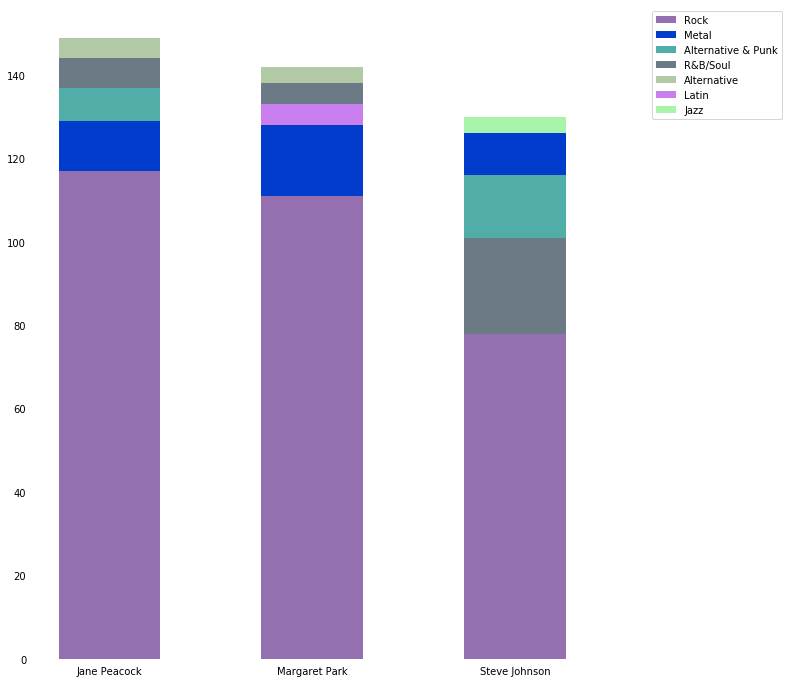

In [17]:
purchase_data = purchase_data.fillna(0)

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)

N = 3
ind = np.arange(N) 
width = 0.50 

bar_list = []
genre_dict = {}

plt.tick_params(bottom = False, left = False, labelbottom = True)

for j, name in enumerate(employee_data_dict):
    data = employee_data_dict[name]
    columns = data.columns
    values = data.iloc[0].tolist()
    
    acc = 0
    
    for i, value in enumerate(values, start=0):
        
        genre = genres[genres['name_normalized'] == columns[i]]
        genre_name = genre['name'].values[0]
        genre_color = genre['colors'].values[0]
        
        bar = plt.bar(j, value, width, bottom = acc, color=genre_color)
        if (genre_name not in genre_dict):
            genre_dict[genre_name] = 0
            bar_list.append((bar, genre_name))
        acc += value
        
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(ind)
ax.set_xticklabels(employee_data.index)
ax.legend(tuple(i[0] for i in bar_list), tuple(i[1] for i in bar_list),bbox_to_anchor=(1.1, 1))

Steve Johnson seems to have more tracks from niche genres compared to other employee. May be this is correlate to the higher "gain density" calculated before

---

## <a id='Analyzing-Sales-by-Country'></a> Analyzing Sales by Country
[Back](#Index)

We'll now analyze the sales data for customers from each different country. We'll use the country value from the `customer` table, and ignore the country from the billing address in the invoice table.

We'll calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, we'll group these customers as "`Other`" in your analysis. 

In [18]:
customer_data = run_query('''
    
    -- Country with one costumers are named "Other"
    WITH country_extended AS (
        SELECT 
            CASE 
                WHEN (
                    SELECT COUNT(*)
                    FROM customer
                    WHERE country = c.country
                ) == 1
                THEN "Other"
                ELSE c.country
            END country,
            c.customer_id,
            il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
    -- "Other" in the last position
    SELECT 
        country,
        total_costumers,
        total_sales_value,
        customer_lifetime_value,
        average_order
    FROM (
        -- Total sales from country, if country == 0, sort is 1
        SELECT
            c.country,
            COUNT(DISTINCT c.customer_id) total_costumers,
            SUM(unit_price) total_sales_value,
            SUM(unit_price) / count(distinct c.customer_id) customer_lifetime_value,
            SUM(unit_price) / count(distinct invoice_id) average_order,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM country_extended c
        GROUP BY c.country
    )
    ORDER BY sort ASC, total_costumers DESC
''')
customer_data

,country,total_costumers,total_sales_value,customer_lifetime_value,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


---

## <a id="Visualizing-Sales-by-Country"></a>Visualizing Sales by Country
[Back](#Index)

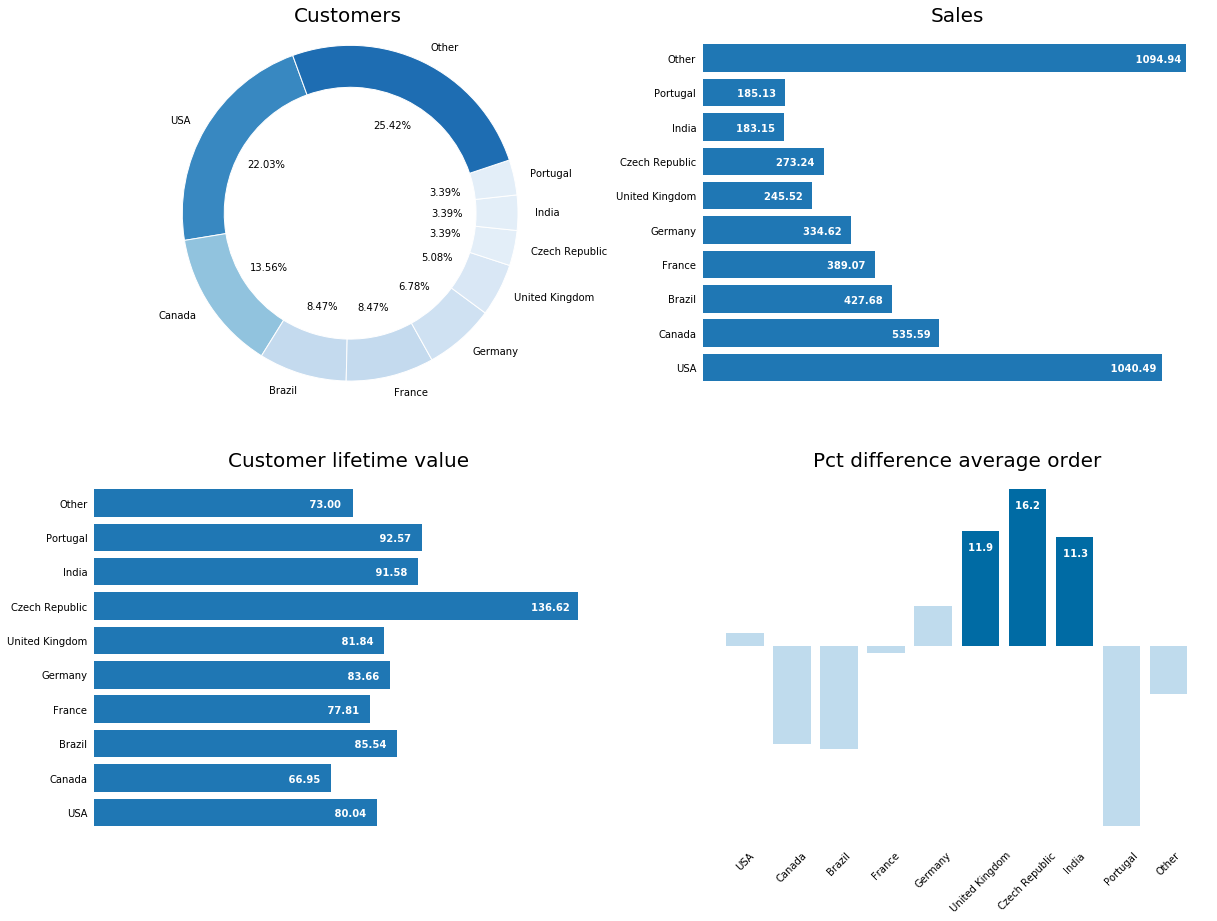

In [50]:
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
#ax1, ax2, ax3, ax4 = axes.flatten()

labels = customer_data['country'].to_list()
total_costumers = customer_data['total_costumers'].to_list()
total_sales_value = customer_data['total_sales_value'].to_list()
customer_lifetime_value = customer_data['customer_lifetime_value'].to_list()
difference_from_avg = customer_data["average_order"] * 100 / customer_data["average_order"].mean() - 100

cmap = plt.get_cmap("Blues")
colors_pie = cmap(np.array(((customer_data['total_costumers']/customer_data['total_costumers'].sum())*3).to_list()))

# Customers - Pie chart

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax1.pie(total_costumers, 
        labels = labels, 
        startangle=110, 
        autopct='%1.2f%%',
        pctdistance=0.58,
        colors=colors_pie,
        wedgeprops=dict(width=0.25, edgecolor='w'))
ax1.set_title('Customers', fontsize=20)
ax1.axis('equal')

# Sales - Horizontal bar

ax2 = fig.add_subplot(222)
ax2.barh(labels, total_sales_value)
ax2.set_title('Sales', fontsize=20)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tick_params(bottom = False, left = False, labelbottom = False)

for i, label in enumerate(labels):
    plt.annotate("{:10.2f}".format(total_sales_value[i]), 
                 (total_sales_value[i]-140, i-0.12),
                 weight='bold', 
                 color='w')
    
# Customer lifetime value - Horizontal bar

ax3 = fig.add_subplot(223)
ax3.barh(labels, customer_lifetime_value)
ax3.set_title('Customer lifetime value', fontsize=20)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tick_params(bottom = False, left = False, labelbottom = False)

for i, label in enumerate(labels):
    plt.annotate("{:10.2f}".format(customer_lifetime_value[i]), 
                 (customer_lifetime_value[i]-17, i-0.12),
                 weight='bold', 
                 color='w')
    
# Pct difference average order - Bar plot

color_difference_from_avg = [blue if diff > 10 else light_blue for diff in difference_from_avg ]
ax4 = fig.add_subplot(224)
ax4.bar(labels, difference_from_avg, color=color_difference_from_avg)
ax4.set_title('Pct difference average order', fontsize=20)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.xticks(rotation=45)
plt.tick_params(bottom = False, left = False, labelbottom = True, labelleft = False)

for i, label in enumerate(labels):
    if difference_from_avg[i] > 10:
        plt.annotate("{:10.1f}".format(difference_from_avg[i]), 
                     (i-0.7, difference_from_avg[i]-2),
                     weight='bold', 
                     color='w')

plt.show()

It seems that **United Kingdom, Czech Republic** and **India** have the higher positive percentage difference from average order anche the mean of all averages, so these are interesting markets. Also, in Czech Republic, we've the highest average value of sales per customer, in India and UK this value is pretty high.

---

## <a id='Albums-vs-Individual-Tracks'></a> Albums vs Individual Tracks
[Back](#Index)

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.